In [ ]:
!nvidia-smi

Fri Feb 11 12:00:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb -q

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 143 kB 42.4 MB/s 
     |████████████████████████████████| 180 kB 34.2 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 


In [ ]:
import numpy as np
import torch
import os
import random
import pandas as pd
import json

from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!mkdir .kaggle/
token = {'username':'','key':''}

with open('/content/.kaggle/kaggle.json','w') as file:
  json.dump(token,file)

In [ ]:
!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json /root/.kaggle/
!kaggle config set -n path -v /content

- path is now set to: /content


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=53c36a6cbde410106bbe132c5b2ccf4ec9fa8acb5ed96f9bc14c70022278de79
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle competitions download -c 11-785-s22-hw1p2

100% 1.85G/1.86G [00:08<00:00, 259MB/s]
100% 1.86G/1.86G [00:08<00:00, 240MB/s]


In [ ]:
!unzip -q /content/competitions/11-785-s22-hw1p2/11-785-s22-hw1p2.zip -d /content/hw1p2/

In [ ]:
LIBRI_PATH = "/content/hw1p2/hw1p2_student_data"
SHUFFLE = True

In [ ]:
len(os.listdir(LIBRI_PATH + "/" + "train-clean-100" + "/mfcc/"))
train_names = os.listdir(LIBRI_PATH + "/" + "train-clean-100" + "/mfcc/")

In [ ]:
class LibriSamples(torch.utils.data.Dataset):
    
    def __init__(self, data_path, sample = 28539, shuffle = True, partition="dev-clean"):
        
        self.sample = sample
        
        self.X_dir = data_path + "/" + partition + "/mfcc/"
        self.Y_dir = data_path + "/" + partition +"/transcript/"
        
        self.X_names = os.listdir(self.X_dir)
        self.Y_names = os.listdir(self.Y_dir)
        if shuffle == True:
            XY_names = list(zip(self.X_names, self.Y_names))
            random.shuffle(XY_names)
            self.X_names, self.Y_names = zip(*XY_names)
        
        assert(len(self.X_names) == len(self.Y_names))
        
        self.length = len(self.X_names)
        
        self.PHONEMES = [
            'SIL',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',  
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '<sos>', '<eos>']
        
    def __len__(self):
        
        return int(np.ceil(self.length / self.sample))
        
    def __getitem__(self, i):
        
        sample_range = range(i*self.sample, min((i+1)*self.sample, self.length))
        
        X, Y = [], []
        for j in sample_range:
            X_path = self.X_dir + self.X_names[j]
            Y_path = self.Y_dir + self.Y_names[j]
            
            label = [self.PHONEMES.index(yy) for yy in np.load(Y_path)][1:-1]

            X_data = np.load(X_path)
            X_data = (X_data - X_data.mean(axis=0))/X_data.std(axis=0)
            X.append(X_data)
            Y.append(np.array(label))
            
        X, Y = np.concatenate(X), np.concatenate(Y)
        
        return X, Y
    
class LibriItems(torch.utils.data.Dataset):
    
    def __init__(self, X, Y, context = 0):
        
        assert(X.shape[0] == Y.shape[0])
        
        self.length  = X.shape[0]
        self.context = context
        
        X = np.pad(X, ((context,context), (0,0)), 'constant', constant_values=(0,0))
        
        self.X, self.Y = X, Y
        
    def __len__(self):
        
        return self.length
        
    def __getitem__(self, i):
        
        c = self.context
        
        xx = self.X[i:(i + 2*c + 1)].flatten()
        yy = self.Y[i]
        
        return xx, yy
    
class LibriTest(torch.utils.data.Dataset):
    
    def __init__(self, data_path, test_order_list, context = 0, record_count = 2620):
        
        assert(len(test_order_list) == record_count)
        
        self.context = context
        
        self.X = []
        for f in test_order_list:
          X_data = np.load(data_path + "/test-clean/mfcc/" + f)
          X_data = (X_data - X_data.mean(axis=0))/X_data.std(axis=0)
          self.X.append(X_data)

        self.X = np.concatenate(self.X)
        self.length  = len(self.X)
        
        self.X = np.pad(self.X, ((context,context), (0,0)), 'constant', constant_values=(0,0))
        
        
    def __len__(self):
        
        return self.length
    
    def __getitem__(self, i):
        
        return self.X[i:(i + 2*self.context + 1)].flatten()

In [ ]:
class Network(torch.nn.Module):
  def __init__(self,size):
    super(Network,self).__init__()
    layers = []
    self.size = size

    for i in range(len(size)-2):
      layers.append(torch.nn.Linear(size[i],size[i+1]))
      layers.append(torch.nn.BatchNorm1d(size[i+1]))
      layers.append(torch.nn.ReLU())
      layers.append(torch.nn.Dropout(0.1))
    
    layers.append(torch.nn.Linear(size[-2],size[-1]))
    self.net = torch.nn.Sequential(*layers)

  def forward(self,x):
    return self.net(x)

In [ ]:
LR         = 0.001
CONTEXT    = 16
BATCH_SIZE = 2048

In [ ]:
model = Network([((CONTEXT*2)+1)*13,512,256,40])

In [ ]:
print(model)

Network(
  (net): Sequential(
    (0): Linear(in_features=429, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=40, bias=True)
  )
)


In [ ]:
device = 'cuda'
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_samples = LibriSamples(data_path = LIBRI_PATH, shuffle=SHUFFLE, partition="train-clean-100")
dev_samples   = LibriSamples(data_path = LIBRI_PATH, shuffle=SHUFFLE, partition="dev-clean")

test_order_list = list(pd.read_csv("/content/hw1p2/test_order.csv").file)
test_items  = LibriTest(data_path = LIBRI_PATH, test_order_list=test_order_list, context = CONTEXT)

In [ ]:
def train_iter(model, optimizer, criterion, context):

    model.train()

    loss_list = []
    for i in tqdm(range(len(train_samples))):

        X, Y = train_samples[i]

        train_items  = LibriItems(X, Y, context=context)
        train_loader = torch.utils.data.DataLoader(train_items, 
                                                   batch_size=BATCH_SIZE, 
                                                   num_workers=2, 
                                                   shuffle=SHUFFLE,
                                                   drop_last=True)

        train_iterator = tqdm(
            iterable = enumerate(train_loader),
            desc     = 'Loss: ', 
            leave    = True, 
            total    = len(train_loader))

        for i, (x, y) in train_iterator:

            x = x.float().to(device)
            y = y.long().to(device)

            optimizer.zero_grad()
            a = model(x)
            loss = criterion(a, y)
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                train_iterator.set_description("Loss: {:.4f}".format(loss.item()))
                train_iterator.refresh()

            loss_list.append(loss.item())

        plt.plot(loss_list[100:])
        plt.draw()
        
        plt.pause(0.001)

In [ ]:
def eval_iter(model, context, eval_samples, epoch, sample_break = 1):

    model.eval()

    true_y_list = []
    pred_y_list = []
    
    for i in tqdm(range(len(eval_samples))):

        X, Y = eval_samples[i]

        eval_items  = LibriItems(X, Y, context=context)
        eval_loader = torch.utils.data.DataLoader(eval_items, 
                                                  batch_size=BATCH_SIZE, 
                                                  shuffle=False)

        eval_iterator = tqdm(
            iterable = enumerate(eval_loader),
            desc     = 'Loss: ', 
            leave    = True, 
            total    = len(eval_loader))

        for i, (x, true_y) in eval_iterator:

            x = x.float().to(device)
            true_y = true_y.long().to(device)

            a = model(x)

            pred_y = torch.argmax(a, axis=1)

            pred_y_list.extend(pred_y.tolist())
            true_y_list.extend(true_y.tolist())
            
        if i + 1 == sample_break:

            break

    accuracy =  accuracy_score(true_y_list, pred_y_list)
    print("Accuracy:", accuracy)
    wandb.log({"Valid Accuracy": accuracy, "Epoch": epoch})
    
    return accuracy, true_y_list, pred_y_list

Epoch num: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/17671 [00:00<?, ?it/s]

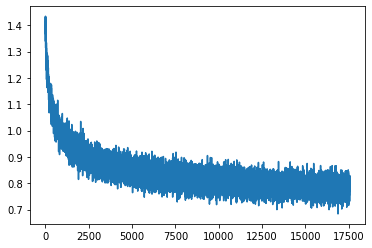

  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/947 [00:00<?, ?it/s]

Accuracy: 0.760981183961154
Epoch num: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/17671 [00:00<?, ?it/s]

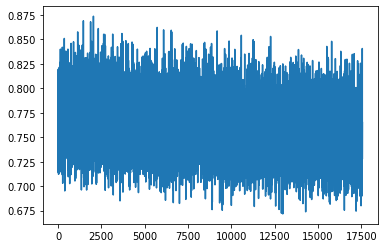

  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/947 [00:00<?, ?it/s]

Accuracy: 0.7691690718329225
Epoch num: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/17671 [00:00<?, ?it/s]

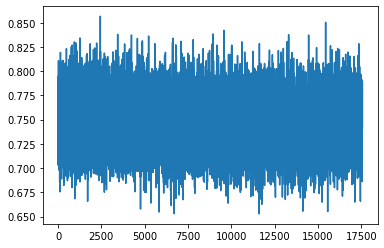

  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/947 [00:00<?, ?it/s]

Accuracy: 0.7730741121530057
Epoch num: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/17671 [00:00<?, ?it/s]

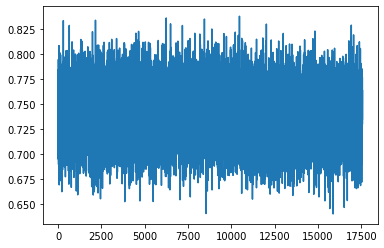

  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/947 [00:00<?, ?it/s]

Accuracy: 0.7755530850128207
Epoch num: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/17671 [00:00<?, ?it/s]

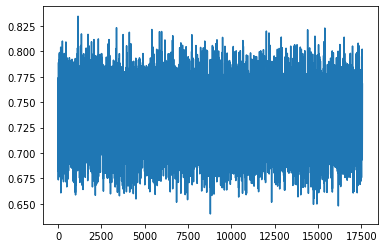

  0%|          | 0/1 [00:00<?, ?it/s]

Loss:   0%|          | 0/947 [00:00<?, ?it/s]

Accuracy: 0.7776852184469026


In [ ]:
wandb.init(project="LOW cutoff",name='medium-cutoff',config={'lr':0.001,'dropout':0.1,'bn':'true','num_layers':2})
wandb.watch(model, log="all")

epochs = 5

for epoch in range(epochs):
  print("Epoch num: "+str(epoch))

  train_iter(model, optimizer, criterion, context=CONTEXT)
    
  with torch.no_grad():
    dev_accuracy, true_y_list, pred_y_list = eval_iter(model, context=CONTEXT, eval_samples=dev_samples, epoch=epoch)
    
  # torch.save(model.state_dict(),"/content/model_7_epoch_"+str(epoch)+".pth")

wandb.finish()